In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from skimage.io import imread, imshow, imsave
from skimage import img_as_float, img_as_ubyte
import numpy as np

## Second assignment
### Точечные и локальные методы обработки изображений
Приложите к отчёту выводы по каждому заданию и код.

Карта разности двух изображений

In [3]:
def diff_card(img1, img2):
    # карта разности двух изображений
    # (img1.shape <= img2.shape! and = is preferred)
    card = np.zeros(img1.shape, np.uint8)
    r, c = img1.shape[0], img1.shape[1]
    for i in range(r):
        for j in range(c):
            if img1[i, j] >= img2[i, j]:
                card[i, j] = np.abs(img1[i, j] - img2[i, j])
            else:
                card[i, j] = np.abs(img2[i, j] - img1[i, j])
    return card

In [4]:
#def diff_card_alternative(img1, img2):
#    return np.abs(img1 - img2)

Состыкованное изображение

In [5]:
def join(img1, img2, jtype='vert'):
    # получить состыкованное изображение
    # (img1.shape = img2.shape!)
    new = np.zeros(img1.shape, np.uint8)
    r, c = img1.shape[0], img1.shape[1]
    if jtype == 'vert':
        new[:, :c//2] = img1[:, :c//2]
        new[:, c//2:] = img2[:, c//2:]
    elif jtype == 'horiz':
        new[:r//2, :] = img1[:r//2, :]
        new[r//2:, :] = img2[r//2:, :]
    return new

### 2.1. Робастное линейное растяжение яркости (ч/б)

Используя стандартные функции постройте гистограмму яркостей изображения.  Примените к изображению операцию «робастное линейное растяжение яркости» (в качестве порога возьмите 5-10% в зависимости от изображения). Включите в отчёт гистограмму, исходное и обработанные изображения, карту разности. Картой разности двух изображений называем изображение, в котором яркость пикселей - это модуль разности между изображениями, т.е. карта разницы - это изображение, на котором показана разница между двумя изображениями.

In [6]:
from matplotlib.pyplot import hist

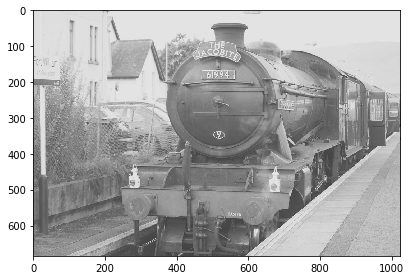

In [7]:
path = 'img_low.jpg'
img1 = imread(path)[:, :, 0]
imshow(img1);

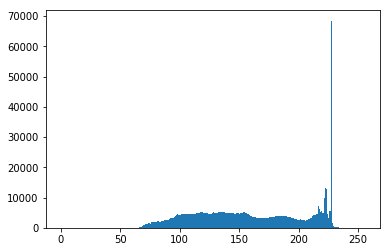

In [8]:
hist(img1.ravel(), bins=range(257));

In [9]:
def stretch(img_c, coef):
    return (img_c - img_c.min()) * (255 - coef) / (img_c.max() - img_c.min())


def linear_bw(img, perc):
    img_f = img.astype('float')
    
    k = round(img.size * perc)  # отбрасываемое
    B = np.sort(img.flatten())  # все значения яркостей пикселей
    Xmin, Xmax = B[k], B[-k]
    
    img_c = np.clip(img_f, Xmin, Xmax)
    new = stretch(img_c, 0)
    
    return new.astype('uint8')

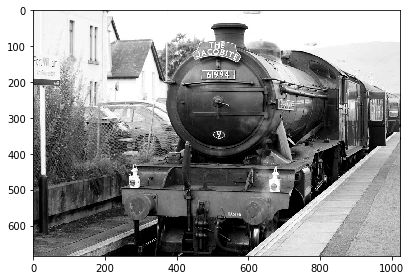

In [10]:
new1_5 = linear_bw(img1, 0.05)  # порог 5%
imshow(new1_5);

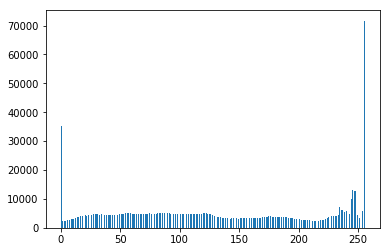

In [11]:
hist(new1_5.ravel(), bins=range(257));

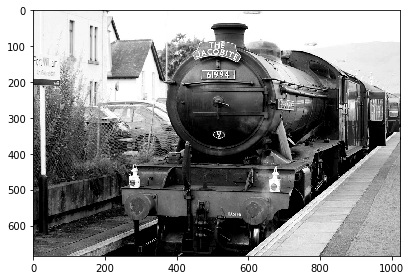

In [12]:
new1_10 = linear_bw(img1, 0.1)  # порог 10%
imshow(new1_10);

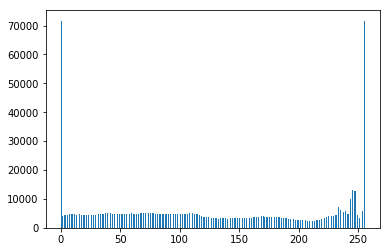

In [13]:
hist(new1_10.ravel(), bins=range(257));

Карты разности

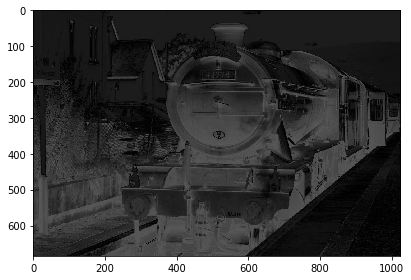

In [14]:
# порог 5%
imshow(diff_card(img1, new1_5));

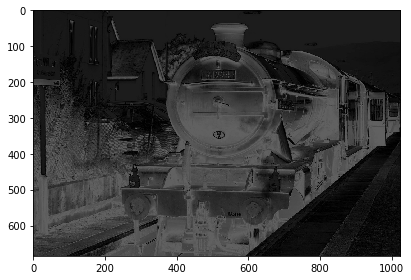

In [15]:
# порог 10%
imshow(diff_card(img1, new1_10));

In [16]:
imshow(diff_card(new1_5, new1_10));

### 2.2. a) Линейное растяжение по каналам (цвет)

Примените операции «линейное растяжение по каналам» и «серый мир» к изображению. Операцию «серый мир» нужно реализовать самостоятельно. Включите в отчёт код и состыкованное изображение результатов применения операций.

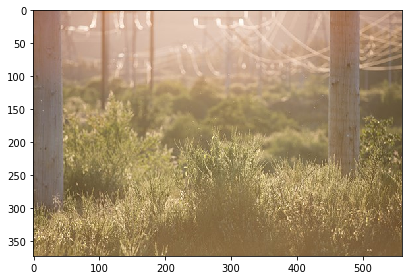

In [17]:
path = 'imgc_low.jpg'
img2a = imread(path)
imshow(img2a);

In [18]:
def linear_color(img, perc):
    img_f = img_as_float(img)
    
    R, G, B = img_f[:, :, 0], img_f[:, :, 1], img_f[:, :, 2]
    Y = 0.299*R + 0.587*G + 0.114*B
    U = -0.1687*R -0.3313*G + 0.5*B + 128
    V = 0.5*R -0.4187*G -0.0813*B + 128
    
    k = round(Y.size * perc)
    B = np.sort(Y.flatten())
    img_c = np.clip(Y, B[k], B[-k-1])
    Xmin, Xmax = img_c.min(), img_c.max()
    
    Y = (Y - Xmin) / (Xmax - Xmin)
    
    Y = np.clip(Y, 0, 1)
    
    R = Y + 1.402*(V - 128)
    G = Y -0.34414*(U - 128) -0.71414*(V - 128)
    B = Y + 1.772*(U - 128)
    
    new = np.dstack((R, G, B))
    new = np.clip(new, 0, 1)
    
    return img_as_ubyte(new)

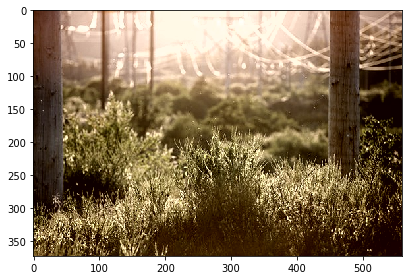

In [19]:
new2a = linear_color(img2a, 0.05)
imshow(new2a);

Состыкованное изображение

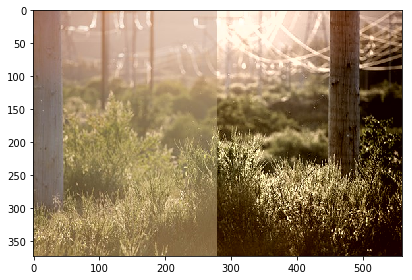

In [20]:
imshow(join(img2a, new2a));

### 2.2. b) Серый мир (цвет)

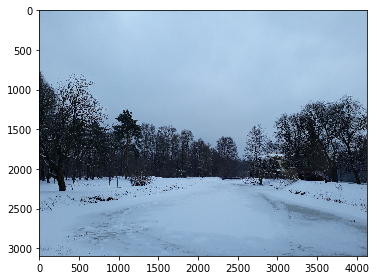

In [21]:
path = 'img_gw.jpg'
img2b = imread(path)
imshow(img2b);

In [22]:
def gray_world(img):
    img_f = img_as_float(img)
    
    R, G, B = img_f[:, :, 0], img_f[:, :, 1], img_f[:, :, 2]
    avg = (np.mean(R) + np.mean(G) + np.mean(B)) / 3
    Rw, Gw, Bw = np.mean(R)/avg, np.mean(G)/avg, np.mean(B)/avg
    
    r, g, b = R/Rw, G/Gw, B/Bw
    
    new = np.dstack((r, g, b))
    new = np.clip(new, 0, 1)
    
    return img_as_ubyte(new)

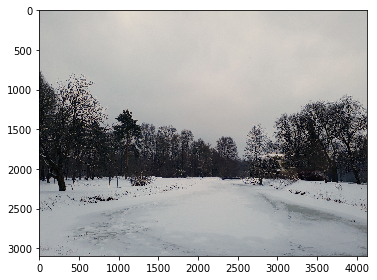

In [23]:
new2b = gray_world(img2b)
imshow(new2b);

Состыковка

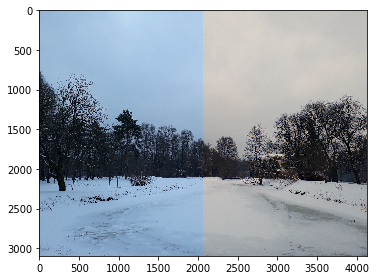

In [24]:
imshow(join(img2b, new2b));

### 2.3. Шум. Медианный фильтр

Зашумите изображение шумом типа «соль и перец». Подавите шум медианным фильтром, попробуйте разные размеры фильтра. Постройте карты разницы между исходным и зашумленным изображениями, и между скорректированным и исходным. Подумайте над способами получения этой разницы. В отчёт вставьте состыкованные исходное/обработанное изображения и карты разницы.

In [25]:
from random import random

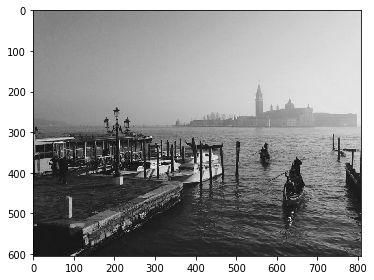

In [26]:
path = 'img_venice.jpg'
img3 = imread(path)[:, :, 1]
imshow(img3);

In [27]:
def sp_noise(img, prob):
    # шум соль и перец
    new = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rdn = random()
            if rdn < prob:
                new[i, j] = 0
            elif rdn > (1 - prob):
                new[i, j] = 255
    return new

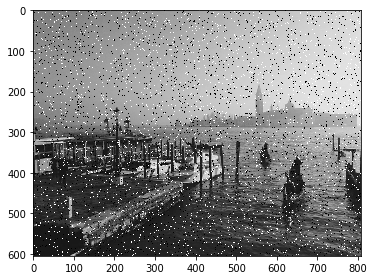

In [28]:
img3_sp = sp_noise(img3, 0.03)
imshow(img3_sp);

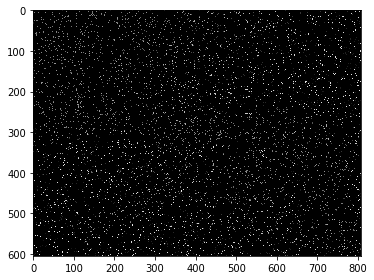

In [29]:
# карта разницы между исходным и зашумленным
imshow(diff_card(img3, img3_sp));

In [30]:
def median_filter(img, a):
    new = img.copy()
    mid = a//2
    for i in range(mid, img.shape[0]-mid):
        for j in range(mid, img.shape[1]-mid):
            median = np.sort(img[i-mid:i+mid+1, j-mid:j+mid+1].flatten())[a**2//2]
            new[i, j] = median
    return new[mid:-mid, mid:-mid]

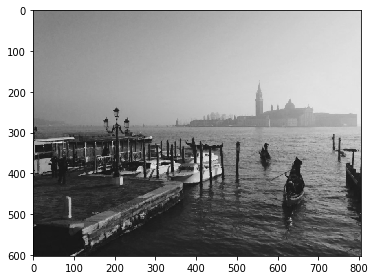

In [31]:
# размер фильтра 3
new3 = median_filter(img3_sp, 3)
imshow(new3);

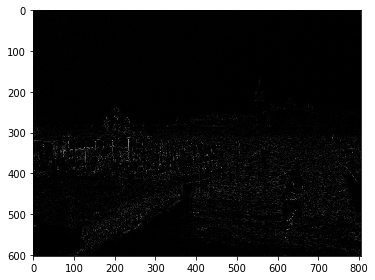

In [32]:
# карта разницы м/у исходным и скорректированным
imshow(diff_card(img3[1:-1, 1:-1], new3));

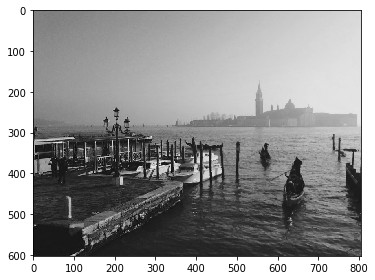

In [33]:
# состыкованное изображение - размер фильтра 3
imshow(join(img3[1:-1, 1:-1], new3));

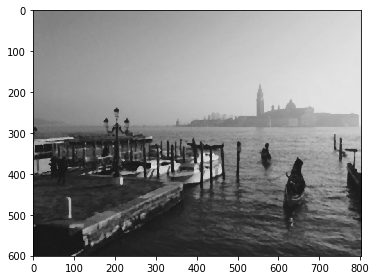

In [34]:
# размер фильтра 5
new3 = median_filter(img3_sp, 5)
imshow(new3);

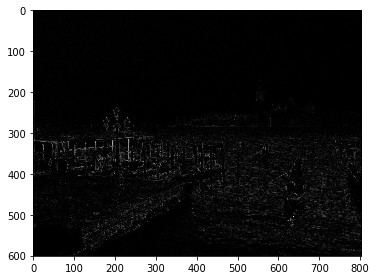

In [35]:
# карта разницы м/у исходным и скорректированным
imshow(diff_card(img3[2:-2, 2:-2], new3));

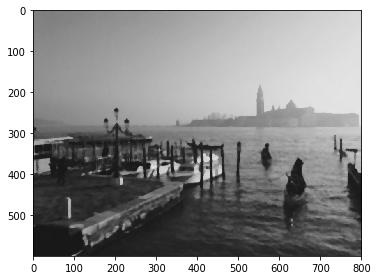

In [36]:
# размер фильтра 7
new3 = median_filter(img3_sp, 7)
imshow(new3);

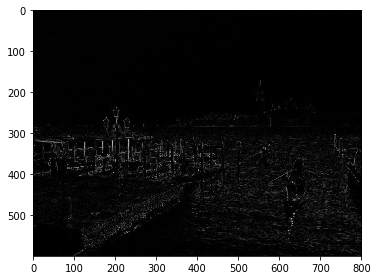

In [37]:
# карта разницы м/у исходным и скорректированным
imshow(diff_card(img3[3:-3, 3:-3], new3));

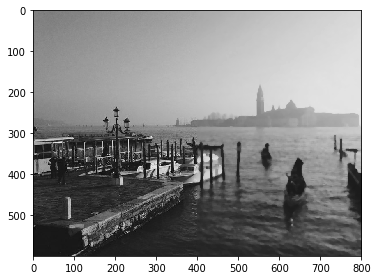

In [38]:
# состыкованное изображение - размер фильтра 7
imshow(join(img3[3:-3, 3:-3], new3));

### 2.4. Свертка. Ядра фильтров

Самостоятельно напишите код для операции свёртки. Примените к изображению свёртки четырьмя разными фильтрами размера 3x3: «усреднение», «сдвиг на 1», «гауссов», «повышение резкости». Для этого подберите разные ядра фильтра. Сравните результат работы собственного фильтра со встроенными функциями, для этого постройте карты разницы изображений. Включите в отчёт исходное и обработанные изображения, карты разности.

In [39]:
from scipy.signal import convolve2d

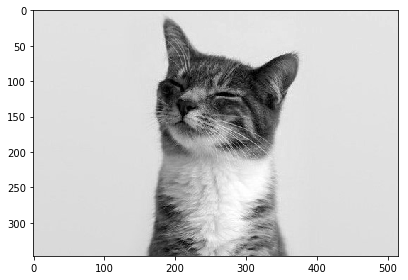

In [40]:
path = 'img_sat.jpg'
img4 = imread(path)[:, :, 1]
imshow(img4);

Операция свертки

In [41]:
def trans_core(core):
    # зеркалирование ядра 3х3 по вертикали и горизонтали
    a = core.shape[0]
    inter = core.copy()
    inter[0], inter[-1] = core[-1], core[0]
    new = inter.copy()
    for i in range(a):
        new[i][0], new[i][-1] = inter[i][-1], inter[i][0]
    return new

In [42]:
def convolve(img, core):
    # свертка
    core = trans_core(core)
    a = core.shape[0]
    m = a//2
    new = img.copy()
    for i in range(m, img.shape[0]-m):
        for j in range(m, img.shape[1]-m):
            new[i,j] = np.clip((img[i-m:i+m+1, j-m:j+m+1] * core).sum(), 0, 255)
    return new[m:-m, m:-m]

Усреднение

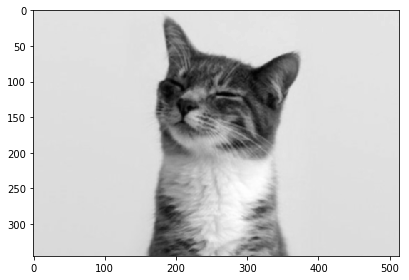

In [43]:
core = np.ones((3,3)) / 9
boxed = convolve(img4, core)
imshow(boxed);

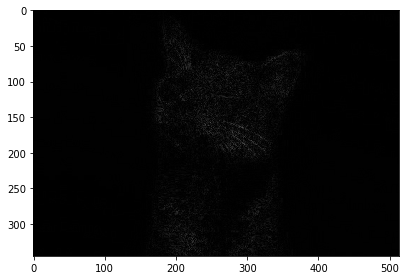

In [44]:
# карта разницы между усредненным своей
# функцией свертки и исходным изображением
imshow(diff_card(img4[1:-1, 1:-1], boxed));

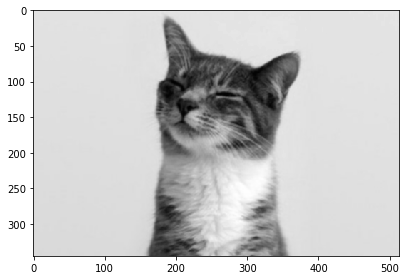

In [45]:
def box(img, box_size):
    box = np.ones((box_size, box_size))
    new = convolve2d(img, box, mode='valid') / box_size**2
    return new.astype('uint8')

fboxed = box(img4, 3)
imshow(fboxed);

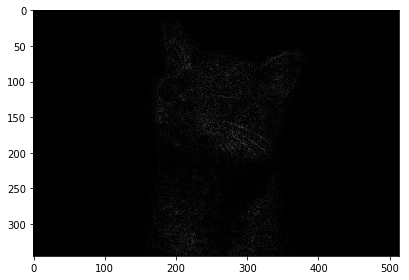

In [46]:
# карта разницы между усредненным box-фильтром
# со встроенной функцией свертки и исходным
imshow(diff_card(img4[1:-1, 1:-1], fboxed));

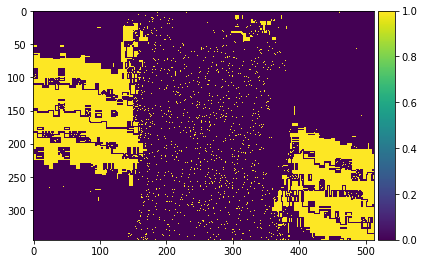

In [47]:
# карта разницы м/у своей функцией свертки и встроенной
imshow(diff_card(boxed, fboxed));

In [48]:
diff_card(boxed, fboxed)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

Сдвиг на 1

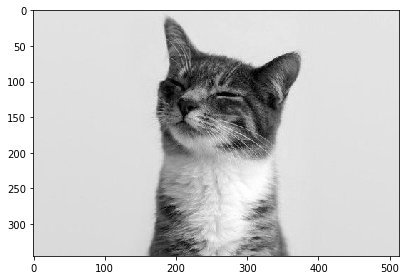

In [49]:
core = np.array([[0,0,0], [0,0,1], [0,0,0]])
shifted = convolve(img4, core)
imshow(shifted);

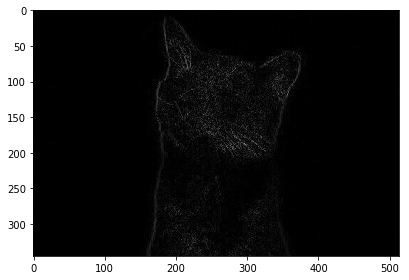

In [50]:
# карта разницы между сдвигом своей
# функцией свертки и исходным изображением
imshow(diff_card(img4[1:-1, 1:-1], shifted));

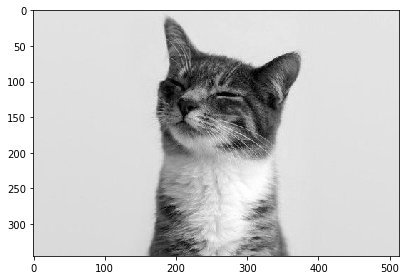

In [51]:
fshifted = convolve2d(img4, core, mode='valid')
fshifted = (np.clip(fshifted, 0, 255)).astype('uint8')
imshow(fshifted);

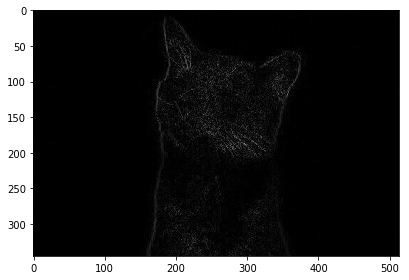

In [52]:
# карта разницы между сдвигом встроенной 
# функцией и исходным изображением
imshow(diff_card(img4[1:-1, 1:-1], fshifted));

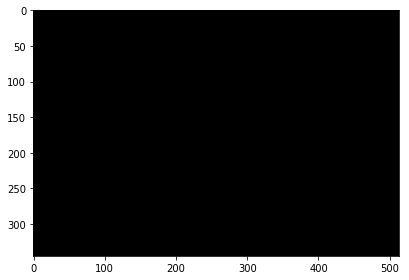

In [53]:
# карта разницы м/у своей функцией свертки и встроенной
imshow(diff_card(shifted, fshifted));

Гауссов

In [54]:
from skimage.filters import gaussian

In [55]:
from numpy import pi, exp

def gauss(x, y, sigma):
    # функция Гаусса
    return exp((-x**2 -y**2) / (2 * sigma**2)) / (2 * pi * sigma**2)

def kernel(sigma):
    # ядро Гауссовского фильтра
    a = int(round(sigma*6) + 1)
    mid = a//2
    K = np.zeros((a, a))

    for i, y in zip(range(0, a), reversed(range(-a+mid+1, a-mid))):
        for j, x in zip(range(0, a), range(-a+mid+1, a-mid)):
            K[i, j] = gauss(x, y, sigma)
    
    K = K / np.sum(K)
    return K

In [56]:
#kernel(1).shape  # (7, 7)

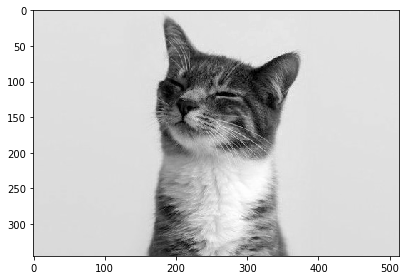

In [57]:
core = kernel(0.33)  # фильтр 3х3
gaussed = convolve(img4, core)
imshow(gaussed);

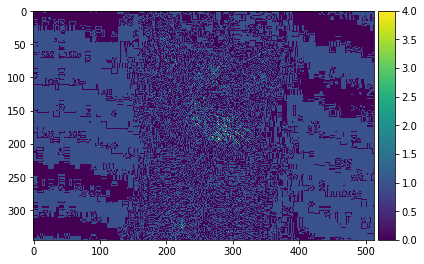

In [58]:
# карта разницы между гауссовым фильтром своей
# функцией свертки и исходным изображением
imshow(diff_card(img4[1:-1, 1:-1], gaussed));

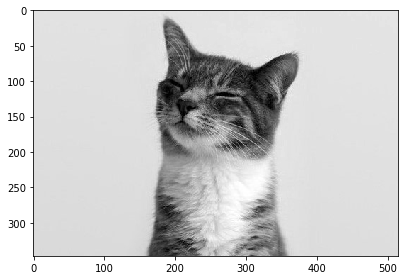

In [59]:
fgaussed = gaussian(img4, sigma=0.33)
imshow(fgaussed);

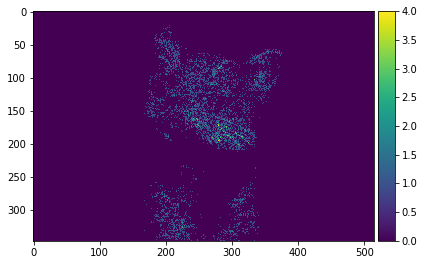

In [60]:
# карта разницы между втроенной функцией и исходным
imshow(diff_card(img4, img_as_ubyte(fgaussed)));

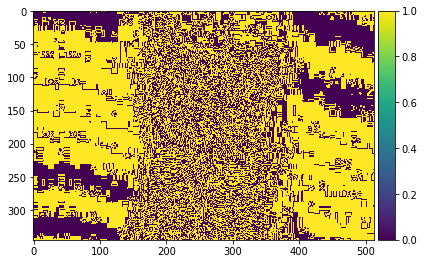

In [61]:
# карта разницы между гауссовым фильтром своей функцией и встроенной
imshow(diff_card(gaussed, img_as_ubyte(fgaussed)[1:-1, 1:-1]));

Повышение резкости

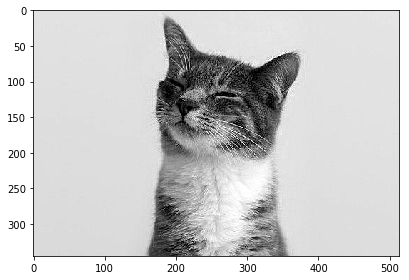

In [62]:
core=np.array([[-1,-2,-1],[-2,22,-2],[-1,-2,-1]])/10
sharpened = convolve(img4, core);
imshow(sharpened);

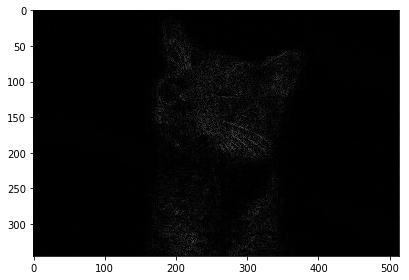

In [63]:
# карта разницы между своим вариантом 
# повышения резкости и исходным
imshow(diff_card(img4[1:-1, 1:-1], sharpened));

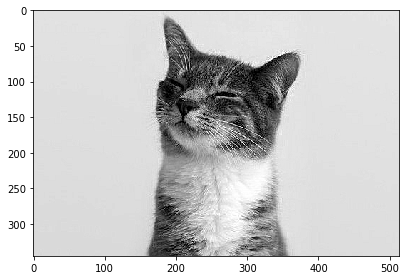

In [64]:
fsharpened = convolve2d(img4, core, mode='valid')
fsharpened = (np.clip(fsharpened, 0, 255)).astype('uint8')
imshow(fsharpened);

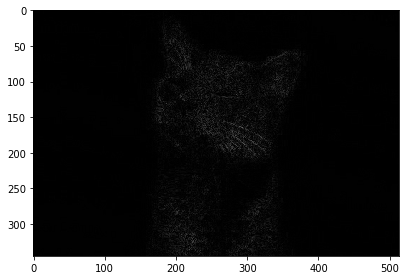

In [65]:
# карта разницы между встроенной сверткой для 
# повышения резкости и исходным
imshow(diff_card(img4[1:-1, 1:-1], fsharpened));

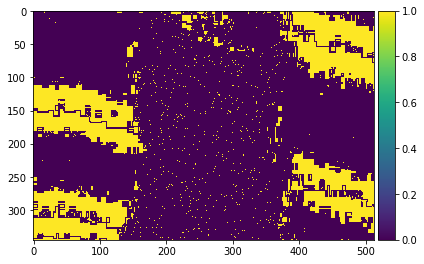

In [66]:
# карта разницы м/у своей реализацией и встроенной
imshow(diff_card(fsharpened, sharpened));

### 2.5. Повышение резкости. Гауссов фильтр

Реализуйте повышение резкости с помощью гауссова фильтра с разными размерами ядра и разными дисперсиями (“unsharp mask”). Сравните результат применения “unsharp mask” и фильтра для повышения резкости. Включите в отчёт исходное и обработанные изображения, карты разности.

In [67]:
def unsharp_mask_custom(img, sigma=0.33, alpha=1):
    # своя unsharp mask
    a = int(round(sigma*6) + 1)
    core = kernel(sigma)
    img_f = img_as_float(img)
    blur = convolve(img_f, core)
    m = a//2
    new = img_f[m:-m, m:-m] + (img_f[m:-m, m:-m] - blur) * alpha
    return img_as_ubyte(np.clip(new, 0, 1))

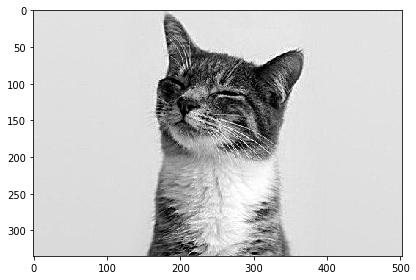

In [68]:
s, a = 2, 1
sharp_21 = unsharp_mask_custom(img4, sigma=s, alpha=a)
imshow(sharp_21);

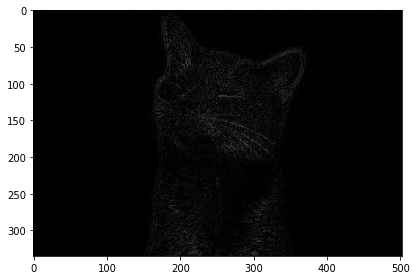

In [69]:
# карта разницы между исходным и обработанным
m = int(round(s*6) + 1)//2
imshow(diff_card(img4[m:-m, m:-m], sharp_21));

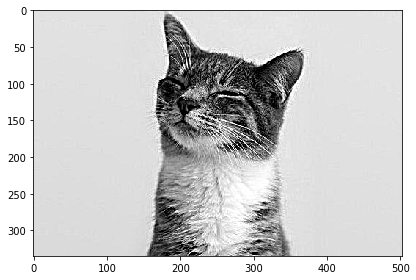

In [70]:
s, a = 2, 2
sharp_22 = unsharp_mask_custom(img4, sigma=s, alpha=a)
imshow(sharp_22);

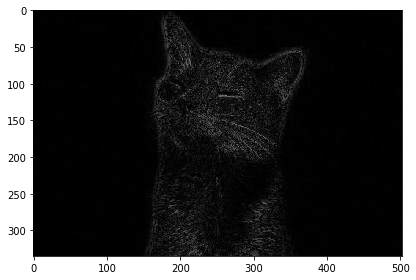

In [71]:
# карта разницы между исходным и обработанным
m = int(round(s*6) + 1)//2
imshow(diff_card(img4[m:-m, m:-m], sharp_22));

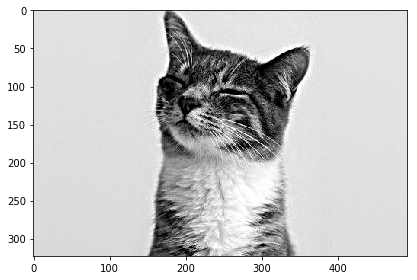

In [72]:
s, a = 4, 1
sharp_41 = unsharp_mask_custom(img4, sigma=s, alpha=a)
imshow(sharp_41);

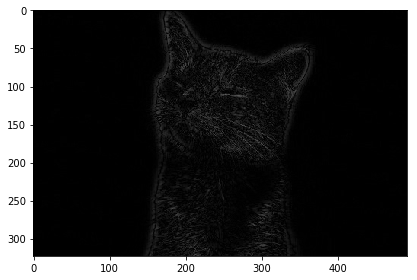

In [73]:
# карта разницы между исходным и обработанным
m = int(round(s*6) + 1)//2
imshow(diff_card(img4[m:-m, m:-m], sharp_41));

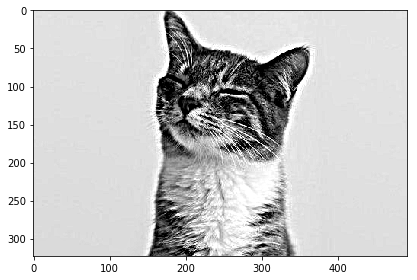

In [74]:
s, a = 4, 2
sharp_42 = unsharp_mask_custom(img4, sigma=s, alpha=a)
imshow(sharp_42);

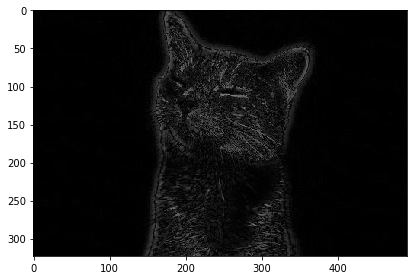

In [75]:
# карта разницы между исходным и обработанным
m = int(round(s*6) + 1)//2
imshow(diff_card(img4[m:-m, m:-m], sharp_42));

Встроенная

In [76]:
#from skimage.filters import unsharp_mask || This is the source code

from __future__ import division
from scipy.ndimage.filters import gaussian_filter


def _unsharp_mask_single_channel(image, radius, amount, vrange):
    blurred = gaussian_filter(image, sigma=radius, mode='reflect')

    result = image + (image - blurred) * amount
    if vrange is not None:
        return np.clip(result, vrange[0], vrange[1], out=result)
    return result


def unsharp_mask(image, radius=1.0, amount=1.0, multichannel=False, preserve_range=False):
    vrange = None  # Range for valid values; used for clipping.
    if preserve_range:
        fimg = image.astype(np.float)
    else:
        fimg = img_as_float(image)
        negative = np.any(fimg < 0)
        if negative:
            vrange = [-1., 1.]
        else:
            vrange = [0., 1.]

    if multichannel:
        result = np.empty_like(fimg, dtype=np.float)
        for channel in range(image.shape[-1]):
            result[..., channel] = _unsharp_mask_single_channel(
                fimg[..., channel], radius, amount, vrange)
        return result
    else:
        return _unsharp_mask_single_channel(fimg, radius, amount, vrange)

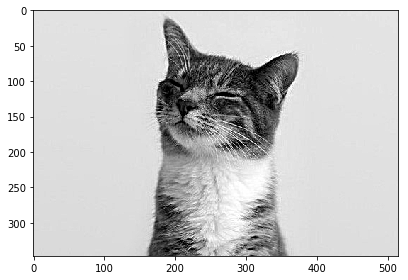

In [77]:
s, a = 2, 1
fsharp_21 = img_as_ubyte(unsharp_mask(img4, radius=s, amount=a))
imshow(fsharp_21);

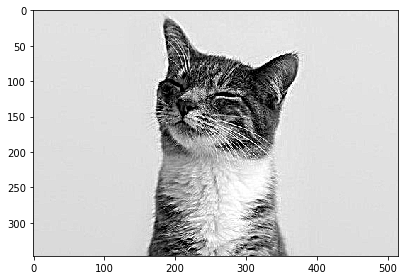

In [78]:
s, a = 2, 2
fsharp_22 = img_as_ubyte(unsharp_mask(img4, radius=s, amount=a))
imshow(fsharp_22);

In [79]:
s, a = 4, 1
fsharp_41 = img_as_ubyte(unsharp_mask(img4, radius=s, amount=a))
imshow(fsharp_41);

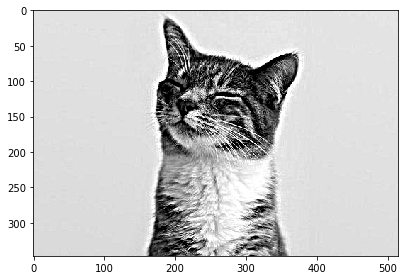

In [80]:
s, a = 4, 2
fsharp_42 = img_as_ubyte(unsharp_mask(img4, radius=s, amount=a))
imshow(fsharp_42);

Карты разницы

In [81]:
s = 2
m = int(round(s*6) + 1)//2
imshow(diff_card(sharp_21, fsharp_21[m:-m, m:-m]));

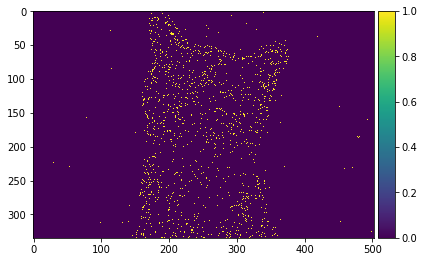

In [82]:
imshow(diff_card(sharp_22, fsharp_22[m:-m, m:-m]));

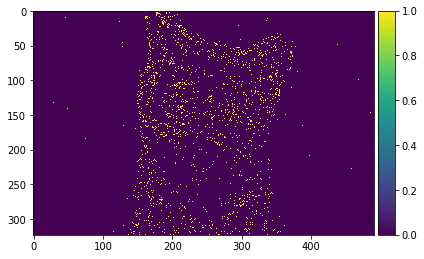

In [83]:
s = 4
m = int(round(s*6) + 1)//2
imshow(diff_card(sharp_41, fsharp_41[m:-m, m:-m]));

In [84]:
imshow(diff_card(sharp_42, fsharp_42[m:-m, m:-m]));